In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [2]:
from PIL import Image
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [3]:
def stats_image(im_path:Path, show_histogram:bool=False):
    """show some information about the image in the given path

    Args:
        im_path (Path): _description_
        show_histogram (bool, optional): _description_. Defaults to False.
    """
    # if im_path is path
    if isinstance(im_path, Path):
      # open image with simpleitk
      im_sitk = sitk.ReadImage(str(im_path))
    else:
      im_sitk = im_path
    # get dtype
    print(f'dtype: {im_sitk.GetPixelIDTypeAsString()}')
    print(f'Get size: {im_sitk.GetSize()}')
    print(f'Get direction: {im_sitk.GetDirection()}')
    print(f'Get spacing: {im_sitk.GetSpacing()}')
    print(f'The origin: {im_sitk.GetOrigin()}')
    # min and max
    print(f'Min: {sitk.GetArrayFromImage(im_sitk).min()}')
    print(f'Max: {sitk.GetArrayFromImage(im_sitk).max()}\n')
    
    if show_histogram:
        im_array = sitk.GetArrayFromImage(im_sitk)
        # min value 32000
        plt.hist(im_array.flatten(), bins=500, range=(32600, im_array.max()))
        plt.show()

First, we must understand that the SET image ranges are different to a conventional mammography, negative numbers are spected (unless shifted) and the backgorund is not 0. For our task the important thing is to be sure that the pixel distributioninside of the mask does not have any irregularities.

In [4]:
# read valid patients num
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_dir = repo_path /'data/images/SET'

# e.g.
id_num = valid_patients.iloc[0].values[0]

# read image
im_path = image_dir / f'Pat_{id_num}_SET_SMC_to_CMC_1min.tif'
im_sitk = sitk.ReadImage(str(im_path))
stats_image(im_sitk, show_histogram=False)

# read segmentation
seg_path = repo_path / f'data/segmentations/L_1_seg/{id_num}_G_L.seg.nrrd'
seg_sitk = sitk.ReadImage(str(seg_path))
stats_image(seg_sitk, show_histogram=False)

dtype: 16-bit unsigned integer
Get size: (2364, 2964)
Get direction: (1.0, 0.0, 0.0, 1.0)
Get spacing: (1.0, 1.0)
The origin: (0.0, 0.0)
Min: 18138
Max: 33186

dtype: 8-bit unsigned integer
Get size: (246, 140, 1)
Get direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Get spacing: (1.0, 1.0, 1.0)
The origin: (1.0, 1838.0, -0.0)
Min: 0
Max: 1



# Create full view binary mask
Expand the ROI in all directions to get a full-image mask

## Solution

In [5]:
def create_binary_mask(seg_sitk:sitk.Image, im_sitk:sitk.Image):
    """expands a segmentation to the size of the image

    Args:
        seg_sitk (sitk.Image): mask to expand
        im_sitk (sitk.Image): image to expand to

    Returns:
        sitk.Image: segmentation expanded to the size of the image
    """
    # define images origin
    im_origin = (int(im_sitk.GetOrigin()[0]), int(im_sitk.GetOrigin()[1]))
    seg_origin = (int(seg_sitk.GetOrigin()[0]), int(seg_sitk.GetOrigin()[1]))
    # remove last dimension
    seg_array = sitk.GetArrayFromImage(seg_sitk)
    seg_array = seg_array[0] # remove z dimension
    # expand array to the left and up using the adding_lu array, careful with dimension order (sitk inversion)
    adding_lu = np.subtract(seg_origin, im_origin)
    seg_array = np.pad(seg_array, ((adding_lu[1],0), (adding_lu[0],0)), 'constant', constant_values=(0,0))
    # expand to the right and down what is left using the image size
    im_size = im_sitk.GetSize()
    adding_rd = np.subtract(im_size[::-1], seg_array.shape) # invert image size tuple
    seg_array = np.pad(seg_array, ((0,adding_rd[0]), (0,adding_rd[1])), 'constant', constant_values=(0,0))
    # check if the image and the segmentation have the same size
    assert seg_array.shape == im_sitk.GetSize()[::-1], 'The image and the segmentation have different sizes'
    # create binary mask
    binary_mask = sitk.GetImageFromArray(seg_array)
    binary_mask.CopyInformation(im_sitk)
    
    return binary_mask

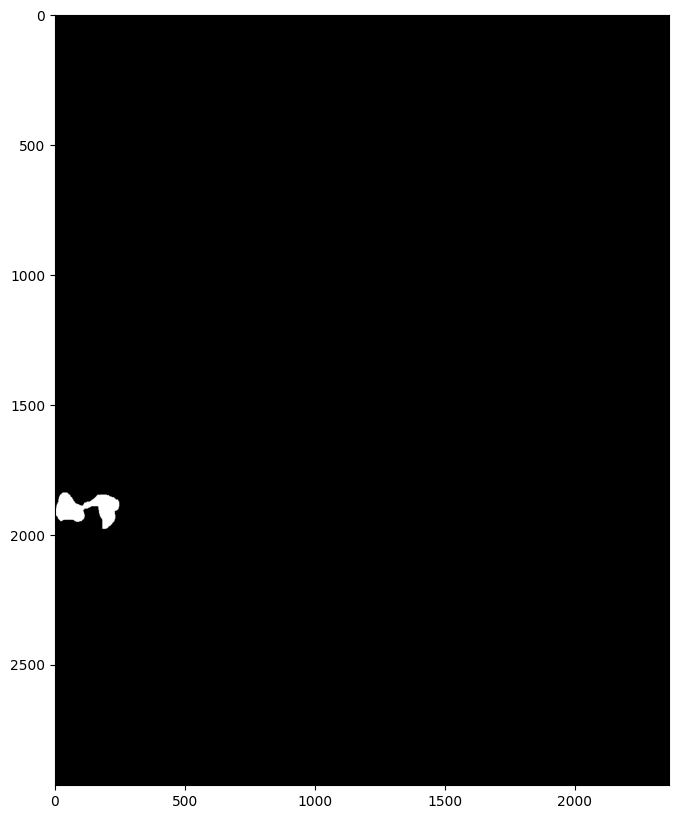

dtype: 8-bit unsigned integer
Get size: (2364, 2964)
Get direction: (1.0, 0.0, 0.0, 1.0)
Get spacing: (1.0, 1.0)
The origin: (0.0, 0.0)
Min: 0
Max: 1



In [6]:
binary_sitk = create_binary_mask(seg_sitk, im_sitk)
binary_array = sitk.GetArrayFromImage(binary_sitk)
plt.figure(figsize=(10,10))
plt.imshow(binary_array, cmap='gray')
plt.show()
stats_image(binary_sitk, show_histogram=False)
# save binary mask as nrrd
sitk.WriteImage(binary_sitk, f'{id_num}_G_L_binary.seg.nrrd')

## Trial steps

expand_lu:[   1 1838]
expand_rd:[ 986 2117]


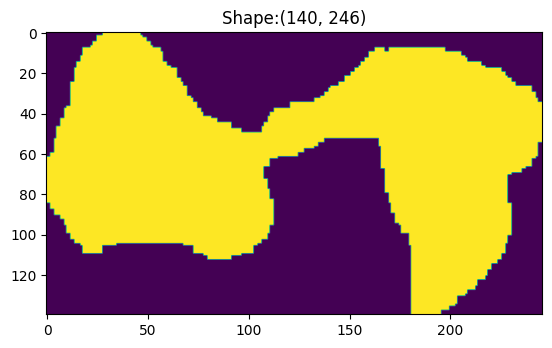

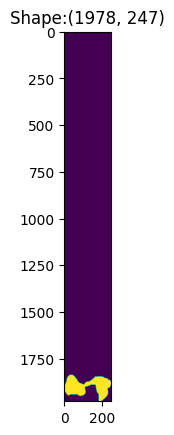

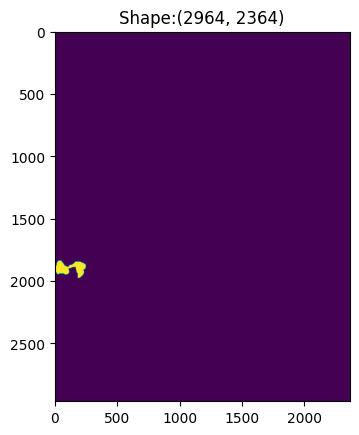

In [7]:
im_origin = (int(im_sitk.GetOrigin()[0]), int(im_sitk.GetOrigin()[1]))
seg_origin = (int(seg_sitk.GetOrigin()[0]), int(seg_sitk.GetOrigin()[1]))

seg_array = sitk.GetArrayFromImage(seg_sitk)
seg_array = seg_array[0] # remove z dimension

plt.figure()
plt.title(f'Shape:{seg_array.shape}')
plt.imshow(seg_array)

adding_lu = np.subtract(seg_origin, im_origin)
print(f'expand_lu:{adding_lu}')
# expand array to the left and up using the adding_lu array, careful with dimension order (sitk inversion)
seg_array = np.pad(seg_array, ((adding_lu[1],0), (adding_lu[0],0)), 'constant', constant_values=(0,0))
plt.figure()
plt.title(f'Shape:{seg_array.shape}')
plt.imshow(seg_array)

# expand to the right and down what is left using the image size
im_size = im_sitk.GetSize()
adding_rd = np.subtract(im_size[::-1], seg_array.shape) # invert image size tuple
print(f'expand_rd:{adding_rd}')
seg_array = np.pad(seg_array, ((0,adding_rd[0]), (0,adding_rd[1])), 'constant', constant_values=(0,0))
plt.figure()
plt.title(f'Shape:{seg_array.shape}')
plt.imshow(seg_array)

# Mask quality

Now that we have the binary mask, we can compute information about the pixels inside of the masks, be sure that they are meaningful and no erouneous regions are being considered.

## First hand check

Text(0.5, 1.0, 'masked image histogram')

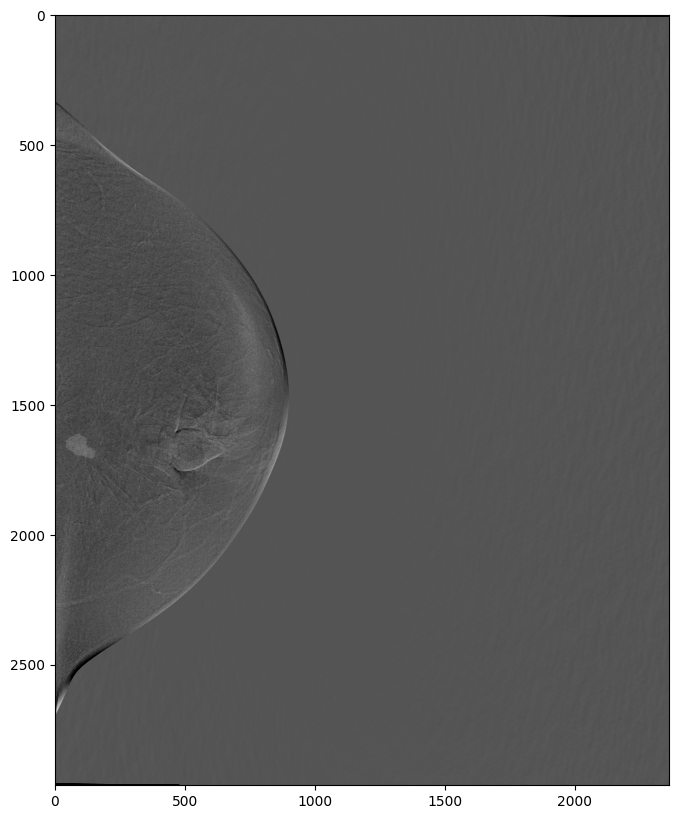

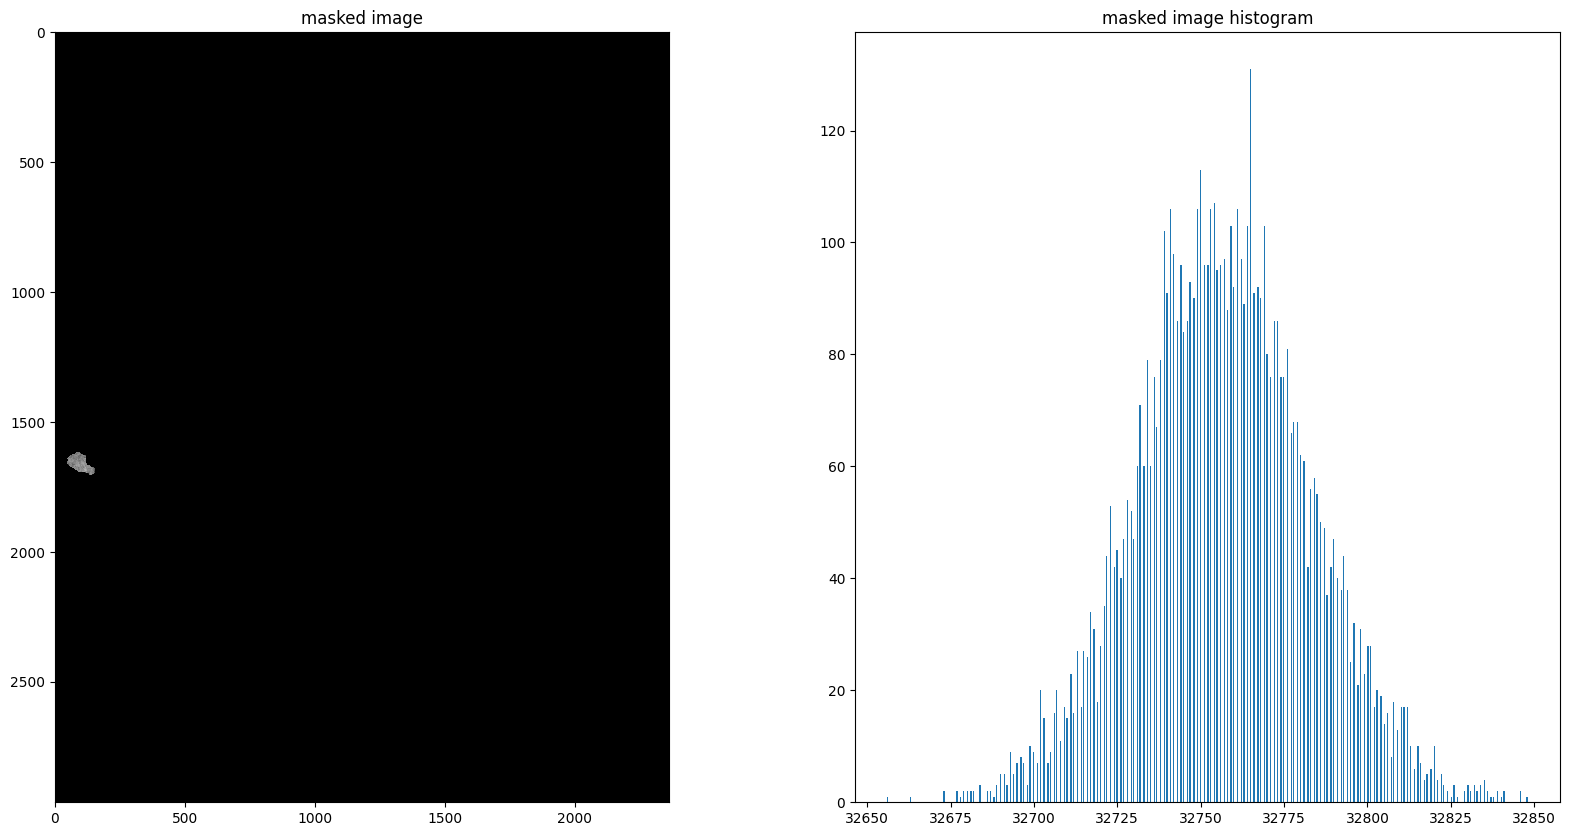

In [8]:
# setting
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_dir = repo_path /'data/images/SET'
binary_dir = repo_path / 'data/binary_masks'

# eg
id_num = valid_patients.iloc[20].values[0]
rad = 'L'
time = '1'

mask_path = binary_dir / f'{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd'
im_path = image_dir / f'Pat_{id_num}_SET_SMC_to_CMC_1min.tif'

# read images
im_sitk = sitk.ReadImage(str(im_path))
mask_sitk = sitk.ReadImage(str(mask_path))
im_array = sitk.GetArrayFromImage(im_sitk)
mask_array = sitk.GetArrayFromImage(mask_sitk)

# important region
masked_im = im_array*mask_array

# superimpose image and mask
plt.figure(figsize=(10,10))
plt.imshow(im_array, cmap='gray', vmin=32600, vmax=im_array.max()) 
plt.imshow(mask_array, cmap='gray', alpha=0.1)
# histogram of roi region
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(masked_im, cmap='gray', vmin=np.unique(masked_im)[1])
axs[1].hist(masked_im.flatten(), bins=500, range=(np.unique(masked_im)[1], masked_im.max()))
axs[0].set_title('masked image')
axs[1].set_title('masked image histogram')

Some statistics can be performed to compute the similarity between the masks.
- mean value
- std value
- pixel range
- pixel count
- Dice score between pairs of masks

This comparision its at the patient-level.<br>

Interestingly enough, this comparison can also be performed using the radiomics deature. We can leave these values for the second phase of this mask quality control.

## Dice and HD for inter and intra observer
Pair-wise Dice is computed and then mean Dice can be obtained per mask.

In [3]:
def dice_computing(mask1:sitk.Image, mask2:sitk.Image):
    """computes the dice coefficient between the image and the mask

    Args:
        mask1 (sitk.Image): image
        mask2 (sitk.Image): mask

    Returns:
        float: dice coefficient
    """
    # get arrays
    mask1 = sitk.GetArrayFromImage(mask1)
    mask2 = sitk.GetArrayFromImage(mask2)
    # compute dice
    dice = 2*np.sum(mask1*mask2)/(np.sum(mask1)+np.sum(mask2))
    return dice

def hausdorff_distance(mask1:sitk.Image, mask2:sitk.Image):
    """compute HD between two masks

    Args:
        mask1 (sitk.Image): mask 1
        mask2 (sitk.Image): mask 2

    Returns:
        float: HD distance as float
    """
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(mask1, mask2)
    return hausdorff.GetHausdorffDistance()

### Radiologist intravaliability

In [10]:
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_dir = repo_path /'data/images/SET'
binary_dir = repo_path / 'data/binary_masks'

# df empty, no columns
df = pd.DataFrame()
# loop over patients
for id_num in valid_patients['pat_num']:
    for rad in ['L', 'M','V']:        
        mask1_path = binary_dir / f'{rad}_1_seg/{id_num}_G_{rad}.seg.nrrd'
        mask2_path = binary_dir / f'{rad}_2_seg/{id_num}_G_{rad}.seg.nrrd'

        # read masks
        mask1_sitk = sitk.ReadImage(str(mask1_path))
        mask2_sitk = sitk.ReadImage(str(mask2_path))
        # compute
        dice = dice_computing(mask1_sitk, mask2_sitk)
        hd = hausdorff_distance(mask1_sitk, mask2_sitk)
        # add to df
        df.loc[id_num, f'{rad}_dice'] = dice
        df.loc[id_num, f'{rad}_hd'] = hd

# save inter observer metrics
save_dir = repo_path / 'data/quality_control'
save_dir.mkdir(exist_ok=True)
df.to_csv(save_dir / 'intra_observer_metrics.csv')

<Axes: title={'center': 'Hausdorff distance'}, ylabel='HD'>

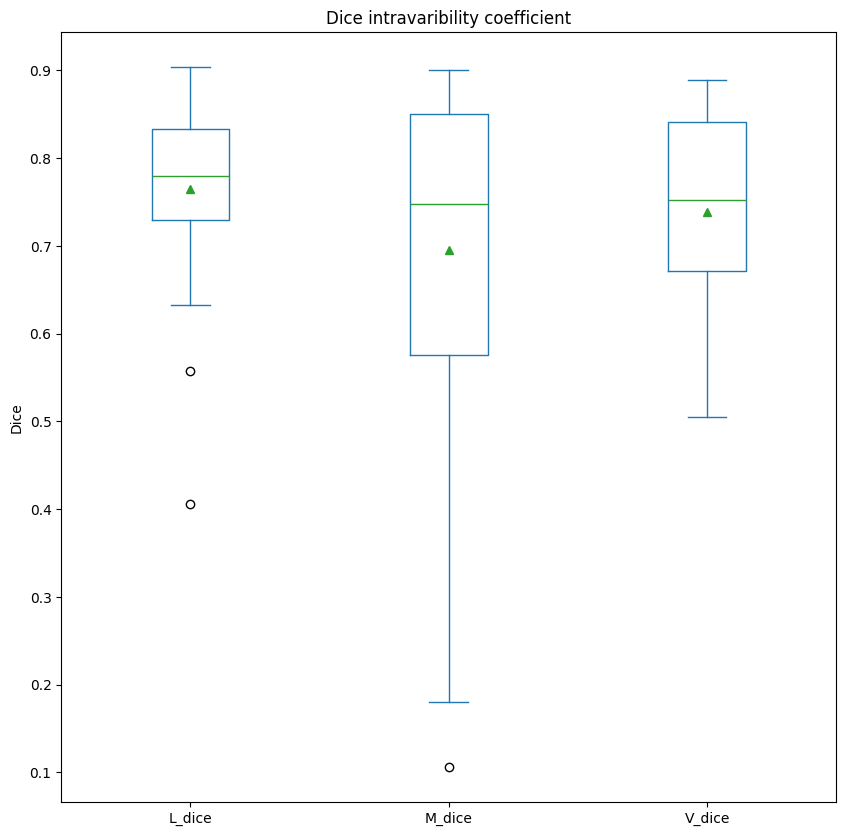

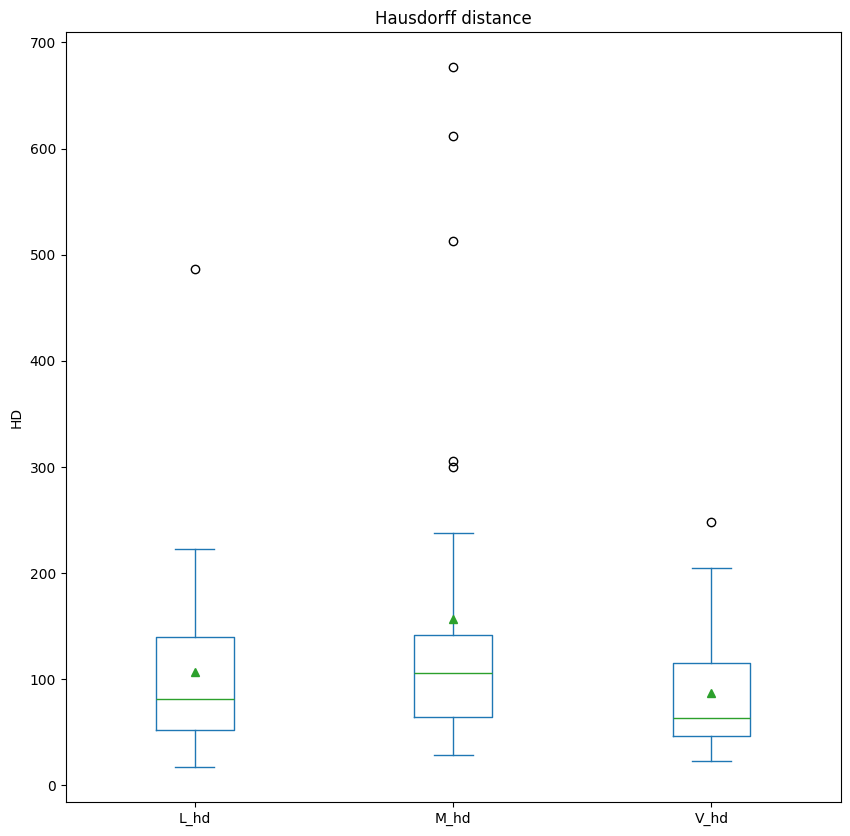

In [10]:
# show the Dice and HD boxplots
df = pd.read_csv(repo_path / 'data/quality_control' / 'intra_observer_metrics.csv', index_col=0)
df_dice = df.filter(regex='dice')
df_dice.plot(kind='box', figsize=(10,10), showfliers=True, showmeans=True, meanline=False, title='Dice intravaribility coefficient', ylabel='Dice')
df_hd = df.filter(regex='hd')
df_hd.plot(kind='box', figsize=(10,10), showfliers=True, showmeans=True, meanline=False, title='Hausdorff distance', ylabel='HD')

### Interobserver variability

In [12]:
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_dir = repo_path /'data/images/SET'
binary_dir = repo_path / 'data/binary_masks'

rad_list = ['L', 'M', 'V']
time_list = ['1', '2']

# df empty, no columns
df = pd.DataFrame()
# loop over patients
for id_num in valid_patients['pat_num']:

    for rad in rad_list:
        for time in time_list:
            main_mask_path = binary_dir / f'{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd'
            mean_dice = []
            mean_hd = []
            for other_rad in rad_list:
                for other_time in time_list:
                    other_mask_path = binary_dir / f'{other_rad}_{other_time}_seg/{id_num}_G_{other_rad}.seg.nrrd'
                    # if paths are the same, skip
                    if other_mask_path == main_mask_path:
                        continue
                    # read masks
                    main_mask_sitk = sitk.ReadImage(str(main_mask_path))
                    other_mask_sitk = sitk.ReadImage(str(other_mask_path))
                    # compute
                    dice = dice_computing(main_mask_sitk, other_mask_sitk)
                    hd = hausdorff_distance(main_mask_sitk, other_mask_sitk)
                    # append
                    mean_dice.append(dice)
                    mean_hd.append(hd)
            # compute mean
            mean_dice = np.mean(mean_dice)
            mean_hd = np.mean(mean_hd)
            # add to df
            df.loc[id_num, f'{rad}_{time}_dice'] = mean_dice
            df.loc[id_num, f'{rad}_{time}_hd'] = mean_hd
            
# save df
save_dir = repo_path / 'data/quality_control'
save_dir.mkdir(exist_ok=True)
df.to_csv(save_dir / 'inter_observer_metrics.csv')

KeyboardInterrupt: 

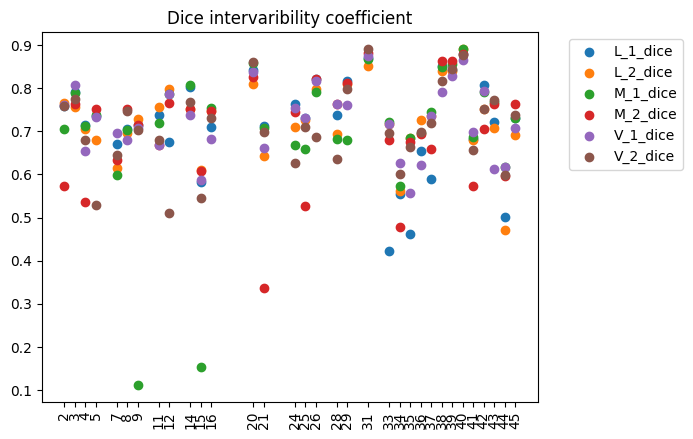

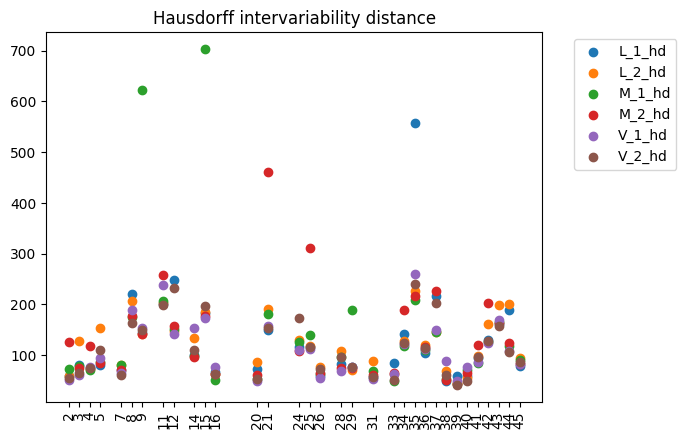

In [20]:
# read df
df_path = repo_path / 'data/quality_control' / 'inter_observer_metrics.csv'
df = pd.read_csv(df_path, index_col=0)

# plot Dice intervaribility coefficient
plt.figure()
plt.title('Dice intervaribility coefficient')
for column in df.columns:
    if 'dice' in column:
        plt.scatter(x=df[column].index, y=df[column].values, label=column)
# show legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(df.index, df.index, rotation='vertical')

# same with hausdorff distance
plt.figure()
plt.title('Hausdorff intervariability distance')
for colu in df.filter(regex='hd').columns:
    plt.scatter(x=df[colu].iloc[:].index, y=df[colu].iloc[:].values, label=colu)
# show legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(df.index, df.index, rotation='vertical')
plt.show()

From these graphs we can see that 5 cases (9, 15, 21, 25, 35) have problems with both Dice and HD between on seg instance and the rest.<br>
The solution for the oversegmentation cases will be to get the intersecion between the problematic mask and the union of the rest (cases 9, 15, and 35).<br>
For cases 21 and 25, an undersegmentation occured so the union between the original mask and the intersection of the rest will be used.

- Error cases:
    - M_1: 9, 15
    - M_2: 21, 25
    - L_1: 35

### Solving mask issues

In [86]:
def operate_masks(rad:str, time:str, id_num:str, mode=str):
    # im info
    images_dir = repo_path / 'data/images/SET'
    case_image = images_dir / f'Pat_{id_num}_SET_SMC_to_CMC_1min.tif'
    mask_shape = sitk.ReadImage(str(case_image)).GetSize()[::-1]
    # variables
    rad_list = ['L', 'M', 'V']
    time_list = ['1', '2']

    # read and unify all other masks
    list_other_masks = []
    for other_rad in rad_list:
        for other_time in time_list:
            if other_rad == rad and other_time == time: # skip same mask
                continue
            other_mask_path = binary_dir / f'{other_rad}_{other_time}_seg/{id_num}_G_{other_rad}.seg.nrrd'
            # read other mask
            other_mask = sitk.ReadImage(str(other_mask_path))
            other_mask = sitk.GetArrayFromImage(other_mask).astype(bool)
            list_other_masks.append(other_mask)

    # apply or operation to all other masks
    other_operated = np.zeros(mask_shape) if mode=='union' else np.ones(mask_shape)
    for other_mask in list_other_masks:
        if mode=='union':
            other_operated = np.logical_or(other_operated, other_mask) 
        elif mode=='intersection':
            other_operated = np.logical_and(other_operated, other_mask)
        else:
            raise ValueError('mode must be union or intersection')
    # turn into uint8
    other_operated = other_operated.astype(np.uint8)

    return other_operated

In [111]:
# settings
binary_dir = repo_path / 'data/binary_masks'
fixed_binary_dir = repo_path / 'data/fixed_binary_masks'


# cases
overseg_cases = ['9-M_1', '15-M_1', '35-L_1']
underseg_cases = ['21-M_2', '25-M_2']

# oversegmentation correction
for case in overseg_cases:
    # names
    id_num = case.split('-')[0]
    rad = case.split('-')[1].split('_')[0]
    time = case.split('-')[1].split('_')[1]

    # read problematic mask and get union of rest
    case_mask_path = binary_dir / f'{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd'
    case_mask = sitk.ReadImage(str(case_mask_path))
    case_mask_array = sitk.GetArrayFromImage(case_mask)
    union_array = operate_masks(rad, time, id_num, mode='union')

    # compute intersection
    intersection_array = np.logical_and(case_mask_array, union_array).astype(np.uint8)
    # # show original and intersection superimposed
    # plt.figure(figsize=(10,10))
    # plt.imshow(case_mask_array, cmap='jet')union
    # plt.imshow(intersection_array, cmap='jet', alpha=0.5)

    # save intersection
    intersection_sitk = sitk.GetImageFromArray(intersection_array)
    intersection_sitk.CopyInformation(case_mask)
    sitk.WriteImage(intersection_sitk, fixed_binary_dir / f'{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd')

# undersegmentation correction
for case in underseg_cases:
    # names
    id_num = case.split('-')[0]
    rad = case.split('-')[1].split('_')[0]
    time = case.split('-')[1].split('_')[1]

    # read problematic mask and get intersection of rest
    case_mask_path = binary_dir / f'{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd'
    case_mask = sitk.ReadImage(str(case_mask_path))
    case_mask_array = sitk.GetArrayFromImage(case_mask)
    intersection_array = operate_masks(rad, time, id_num, mode='union')

    # compute union
    union_array = np.logical_or(case_mask_array, intersection_array).astype(np.uint8)
    # show original and intersection superimposed
    # plt.figure(figsize=(10,10))
    # plt.imshow(case_mask_array, cmap='gray')
    # plt.imshow(intersection_array, cmap='jet', alpha=0.7)

    # save union
    union_sitk = sitk.GetImageFromArray(union_array)
    union_sitk.CopyInformation(case_mask)
    sitk.WriteImage(union_sitk, fixed_binary_dir / f'{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd')

Check Dice and HD after correction


In [112]:
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_dir = repo_path /'data/images/SET'
binary_dir = repo_path / 'data/fixed_binary_masks'

rad_list = ['L', 'M', 'V']
time_list = ['1', '2']

# df empty, no columns
df = pd.DataFrame()
# loop over patients
for id_num in valid_patients['pat_num']:

    for rad in rad_list:
        for time in time_list:
            main_mask_path = binary_dir / f'{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd'
            mean_dice = []
            mean_hd = []
            for other_rad in rad_list:
                for other_time in time_list:
                    other_mask_path = binary_dir / f'{other_rad}_{other_time}_seg/{id_num}_G_{other_rad}.seg.nrrd'
                    # if paths are the same, skip
                    if other_mask_path == main_mask_path:
                        continue
                    # read masks
                    main_mask_sitk = sitk.ReadImage(str(main_mask_path))
                    other_mask_sitk = sitk.ReadImage(str(other_mask_path))
                    # compute
                    dice = dice_computing(main_mask_sitk, other_mask_sitk)
                    hd = hausdorff_distance(main_mask_sitk, other_mask_sitk)
                    # append
                    mean_dice.append(dice)
                    mean_hd.append(hd)
            # compute mean
            mean_dice = np.mean(mean_dice)
            mean_hd = np.mean(mean_hd)
            # add to df
            df.loc[id_num, f'{rad}_{time}_dice'] = mean_dice
            df.loc[id_num, f'{rad}_{time}_hd'] = mean_hd
            
# save df
save_dir = repo_path / 'data/quality_control'
save_dir.mkdir(exist_ok=True)
df.to_csv(save_dir / 'fixed_inter_observer_metrics.csv')

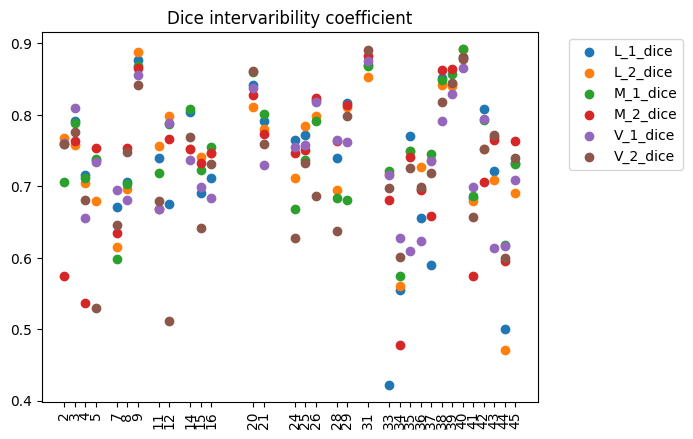

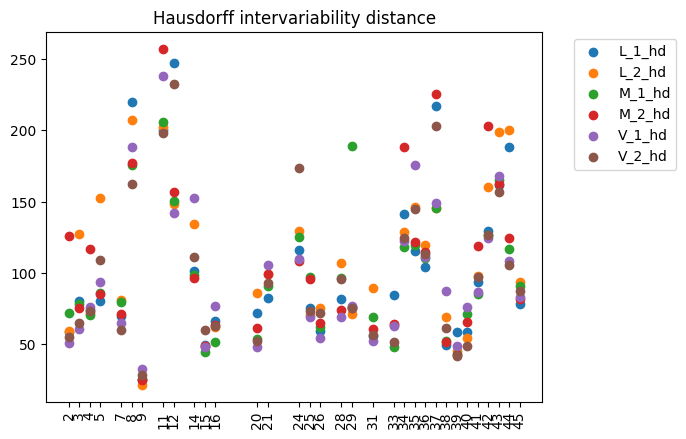

In [113]:
# read df
df_path = repo_path / 'data/quality_control' / 'fixed_inter_observer_metrics.csv'
df = pd.read_csv(df_path, index_col=0)

# plot Dice intervaribility coefficient
plt.figure()
plt.title('Dice intervaribility coefficient')
for column in df.columns:
    if 'dice' in column:
        plt.scatter(x=df[column].index, y=df[column].values, label=column)
# show legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(df.index, df.index, rotation='vertical')

# same with hausdorff distance
plt.figure()
plt.title('Hausdorff intervariability distance')
for colu in df.filter(regex='hd').columns:
    plt.scatter(x=df[colu].iloc[:].index, y=df[colu].iloc[:].values, label=colu)
# show legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(df.index, df.index, rotation='vertical')
plt.show()

### Range and other first order statistics
For each mask we compute some basic statistcs like:
- mean
- std
- min
- max
- range
- pixel count

In [ ]:
valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
image_dir = repo_path /'data/images/SET'
binary_dir = repo_path / 'data/binary_masks'

rad_list = ['L', 'M', 'V']
time_list = ['1', '2']

# df empty, no columns
df = pd.DataFrame()
# loop over patients
for id_num in tqdm(valid_patients['pat_num']):
    im_path = im_path = image_dir / f'Pat_{id_num}_SET_SMC_to_CMC_1min.tif'
    im_sitk = sitk.ReadImage(str(im_path))
    im_array = sitk.GetArrayFromImage(im_sitk)
    for rad in rad_list:
        for time in time_list:
            mask_path = binary_dir / f'{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd'
            mask_sitk = sitk.ReadImage(str(mask_path))
            mask_array = sitk.GetArrayFromImage(mask_sitk)
            # compute mean of only pixels inside of the mask region
            mean = np.mean(im_array, where=mask_array==1)
            std = np.std(im_array, where=mask_array==1)
            min_val = np.min(im_array, where=mask_array==1, initial=im_array.max())
            max_val = np.max(im_array, where=mask_array==1, initial=im_array.min())
            range_val = max_val - min_val
            pixel_count = np.sum(mask_array)
            # add to df
            df.loc[id_num, f'{rad}_{time}_mean'] = mean
            df.loc[id_num, f'{rad}_{time}_std'] = std
            df.loc[id_num, f'{rad}_{time}_min'] = min_val
            df.loc[id_num, f'{rad}_{time}_max'] = max_val
            df.loc[id_num, f'{rad}_{time}_range'] = range_val
            df.loc[id_num, f'{rad}_{time}_pixel_count'] = pixel_count
# save csv
save_dir = repo_path / 'data/quality_control'
save_dir.mkdir(exist_ok=True)
df.to_csv(save_dir / 'masked-region_statistics.csv')

100%|██████████| 33/33 [00:09<00:00,  3.47it/s]


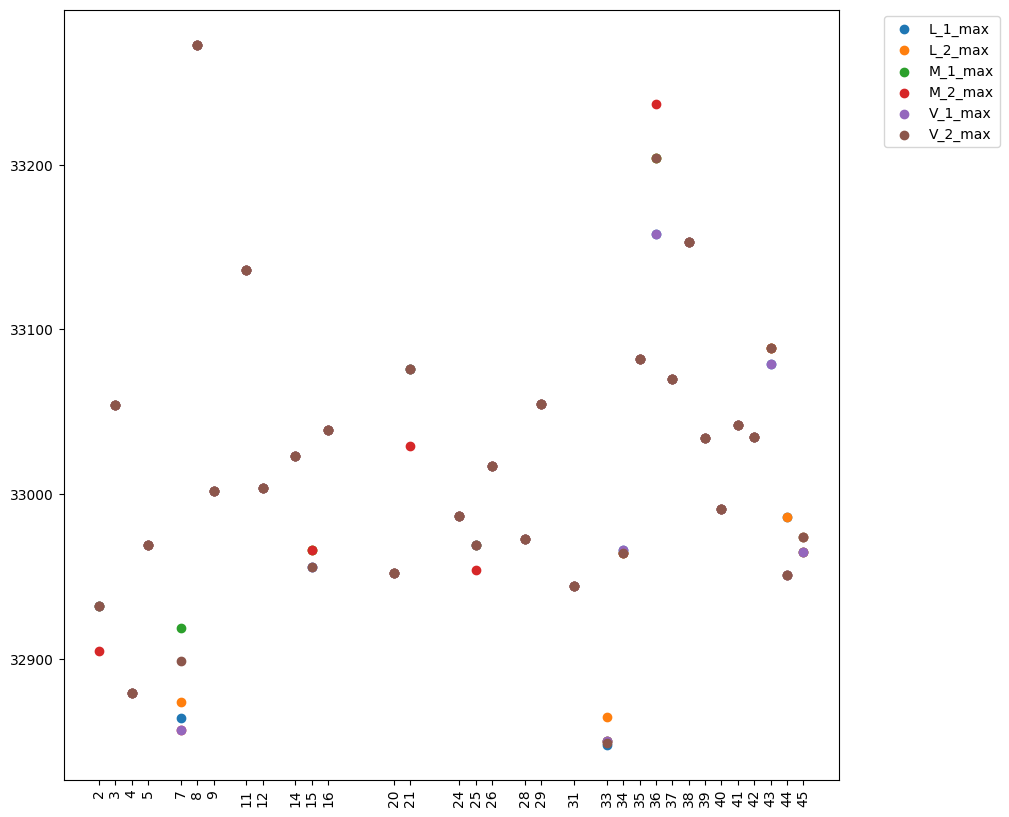

In [ ]:
df_path = repo_path / 'data/quality_control' / 'masked-region_statistics.csv'
df = pd.read_csv(df_path, index_col=0)

plt.figure(figsize=(10,10))
for colu in df.filter(regex='max').columns:
    plt.scatter(x=df[colu].index[:], y=df[colu].values[:], label=colu)
# show all x ticks
plt.xticks(df.index, df.index, rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In general, the pixel values seem to be in order. Only the case 8 represents a quite strange variability in the pixel range